# Full pipeline

This is code for the full pipeline for attractor identification and basin identification.

In [25]:
import pandas as pd

base_path = "/home/jeintron/dev/blf_m/blf-attractor-algorithm/"
path_to_data = f"{base_path}local_data/data_for_icwsm/icwsmtuned_random_invert_0_umap_clustered_35_trace.feather"
output_name = f"{base_path}local_data/labeled_trace_climate_change_icwsm23.feather"

## Step 1: Derive vector field

In [26]:
def derive_transition_grid(data,grid_size):
    df = trace[["u_id","x","y","dt"]]

    df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
    df['y_grid'] = ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min()) * (grid_size - 1)).astype(int)

    # Sort by user and datetime to ensure correct transition order
    df.sort_values(['u_id', 'dt'], inplace=True)

    # Calculate transitions
    df['from_x'] = df['x_grid'].shift(1)
    df['from_y'] = df['y_grid'].shift(1)
    df['to_x'] = df['x_grid']
    df['to_y'] = df['y_grid']

    # Filter out rows that do not represent a transition (first occurrence for each user)
    transitions = df[df['u_id'] == df['u_id'].shift(1)]

    transitions['dx'] = transitions['to_x'] - transitions['from_x']
    transitions['dy'] = transitions['to_y'] - transitions['from_y']
    tx = transitions[['from_x','from_y','dx','dy']]
    return tx


In [123]:
# Underlying grid size
grid_size = 100
trace = pd.read_feather(path_to_data)
tx = derive_transition_grid(trace,grid_size)

/tmp/ipykernel_1114747/416180493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
/tmp/ipykernel_1114747/416180493.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['dx'] = transitions['to_x'] - transitions['from_x']
/tmp/ipykernel_1114747/416180493.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

## Step 2: Bayesian smoothing

In [145]:
import numpy as np

# Utiliity functions to convert between dataframes and grids

def dataframe_to_grid(df):
    # Create mappings from from_x and from_y to indices
    unique_x = np.sort(df['from_x'].unique())
    unique_y = np.sort(df['from_y'].unique())
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize grids for mu and variance
    mu_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    mu_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)

    # Fill grids with values from DataFrame
    for _, row in df.iterrows():
        i = x_to_index[row['from_x']]
        j = y_to_index[row['from_y']]
        mu_dx_grid[i, j] = row['mu_dx']
        mu_dy_grid[i, j] = row['mu_dy']
        var_dx_grid[i, j] = row['var_dx']
        var_dy_grid[i, j] = row['var_dy']
    return mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid

def grid_to_dataframe(mu_dx_grid, mu_dy_grid, x_grid=None, y_grid = None, var_dx_grid = None, var_dy_grid = None):
    data = []
    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dx_grid.shape[1]):
            
            x_coord = i if x_grid is None else x_grid[i,j]
            y_coord = j if y_grid is None else y_grid[i,j]
            row = {
                'from_x': x_coord,
                'from_y': y_coord,
                'mu_dx': mu_dx_grid[i, j],
                'mu_dy': mu_dy_grid[i, j]}
            if var_dx_grid is not None and var_dy_grid is not None:
                row['var_dx']=var_dx_grid[i, j]
                row['var_dy'] = var_dy_grid[i, j]
            data.append(row)

    return pd.DataFrame(data)

# Bayesian updating

def bayesian_update(mu_prior, var_prior, mean_sample, var_sample, count, epsilon=1e-10):
    if count == 0:
        return mu_prior, var_prior
    if count==1:
        #var_sample = (var_prior + epsilon) / 2
        var_sample = np.max([var_prior, var_sample])  # Use maximum variance for single samples
    if var_sample==0:
        var_sample = epsilon
    precision_prior = 1 / var_prior
    #precision_sample = 1 / var_sample
    precision_sample = count / var_sample  # Scale precision by count
    combined_precision = precision_prior + count * precision_sample
    mu_posterior = (precision_prior * mu_prior + count * precision_sample * mean_sample) / combined_precision
    var_posterior = count / combined_precision
    return mu_posterior, var_posterior


def prepare_cell_data(df):
    # Group by 'from_x' and 'from_y' and calculate mean and variance
    grouped = df.groupby(['from_x', 'from_y'])
    summary = grouped.agg({
        'dx': ['mean', 'var'],
        'dy': ['mean', 'var','count'],
        
    }).reset_index()
    summary.columns = ['from_x', 'from_y', 'dx_mean', 'dx_var', 'dy_mean', 'dy_var','n']
    # Replace NaN variances (which occur if there's only one sample) with a small positive number
    summary.fillna({'dx_var': 1e-10, 'dy_var': 1e-10}, inplace=True)
    return summary

def process_df(df, mu_prior, var_prior):
    data = prepare_cell_data(df)
    results = []
    for _, row in data.iterrows():
        # Bayesian updates for dx and dy
        mu_dx, var_dx = bayesian_update(mu_prior, var_prior, row['dx_mean'], row['dx_var'], row['n'])
        mu_dy, var_dy = bayesian_update(mu_prior, var_prior, row['dy_mean'], row['dy_var'], row['n'])
        results.append([row['from_x'], row['from_y'], mu_dx, var_dx, mu_dy, var_dy])

    results_df = pd.DataFrame(results, columns=['from_x', 'from_y', 'mu_dx', 'var_dx', 'mu_dy', 'var_dy'])

    # Spatial smoothing would be applied here, using spatial_weighted_average
    return results_df

# Spatial smoothing

def spatial_weighted_average(grid, i, j, radius, mu_grid, var_grid):
    weighted_mu, weighted_var, total_weight = 0, 0, 0
    for di in range(-radius, radius + 1):
        for dj in range(-radius, radius + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < grid.shape[0] and 0 <= nj < grid.shape[1]: #and (di != 0 or dj != 0):
                #weight = 1 / (1 + abs(di) + abs(dj))  # Example weighting scheme:
                if np.isnan(mu_grid[ni, nj]):
                    continue
                dist = np.sqrt(di**2 + dj**2)# + 1e-10
                weight = 1 / (1+dist) if dist > 0 else 1.0
                weighted_mu += weight * mu_grid[ni, nj]
                weighted_var += weight * var_grid[ni, nj]
                total_weight += weight
    if total_weight > 0:
        return weighted_mu / total_weight, weighted_var / total_weight
    return mu_grid[i, j], var_grid[i, j]

def apply_spatial_smoothing(mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid, radius):
    smoothed_mu_dx_grid = np.copy(mu_dx_grid)
    smoothed_mu_dy_grid = np.copy(mu_dy_grid)
    smoothed_var_dx_grid = np.copy(var_dx_grid)
    smoothed_var_dy_grid = np.copy(var_dy_grid)

    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dy_grid.shape[1]):
            if not np.isnan(mu_dx_grid[i, j]):
                smoothed_mu_dx_grid[i, j], smoothed_var_dx_grid[i, j] = spatial_weighted_average(
                    mu_dx_grid, i, j, radius, mu_dx_grid, var_dx_grid)
                smoothed_mu_dy_grid[i, j], smoothed_var_dy_grid[i, j] = spatial_weighted_average(
                    mu_dy_grid, i, j, radius, mu_dy_grid, var_dy_grid)

    return smoothed_mu_dx_grid, smoothed_mu_dy_grid, smoothed_var_dx_grid, smoothed_var_dy_grid


# Plotting for inspection
import matplotlib.pyplot as plt

def plot_vector_field(df, scale=1):
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        angles='xy', scale_units='xy', scale=1,
        pivot='mid'
    )
    
    
    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field')
    plt.grid(True)
    plt.show()


def plot_vector_field_with_var(df, scale=1):
    # Calculate the average variance for coloring
    df['avg_var'] = (df['var_dx'] + df['var_dy']) / 2
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        df['avg_var'],  # Use average variance for coloring
        angles='xy', scale_units='xy', scale=1,
        cmap='viridis', pivot='mid'
    )
    
    # Adding a color bar to show the variance
    cbar = fig.colorbar(Q, ax=ax)
    cbar.set_label('Average Variance of Vector Components')

    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field with Variance Indication')
    plt.grid(True)
    plt.show()


def plot_speed_map(df):
    # Calculate the speed (magnitude of velocity vector)
    df['avg_mu'] = np.sqrt(df['mu_dx']**2 + df['mu_dy']**2)
    
    # Get unique x and y coordinates in sorted order
    x_unique = np.sort(df['from_x'].unique())
    y_unique = np.sort(df['from_y'].unique())
    
    # Create a meshgrid for proper orientation
    X, Y = np.meshgrid(x_unique, y_unique)
    
    # Create the speed grid
    speed_grid = np.zeros((len(y_unique), len(x_unique)))
    for i, x in enumerate(x_unique):
        for j, y in enumerate(y_unique):
            mask = (df['from_x'] == x) & (df['from_y'] == y)
            if any(mask):
                speed_grid[j, i] = df.loc[mask, 'avg_mu'].iloc[0]
    
    # Plotting the speed map
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.pcolormesh(X, Y, speed_grid, cmap='viridis')
    
    # Adding a color bar
    cbar = fig.colorbar(Q, ax=ax)
    cbar.set_label('Speed (Magnitude of Vector)')

    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Speed Map')
    plt.grid(True)
    plt.show()

In [130]:
smoothed = process_df(tx, 0,1)
mu_dx,mu_dy,var_dx,var_dy = dataframe_to_grid(smoothed)


In [131]:

mu_dx,mu_dy,var_dx,var_dy = apply_spatial_smoothing(mu_dx,mu_dy,var_dx,var_dy,2)
averaged = grid_to_dataframe(mu_dx,mu_dy,var_dx_grid=var_dx,var_dy_grid=var_dy)


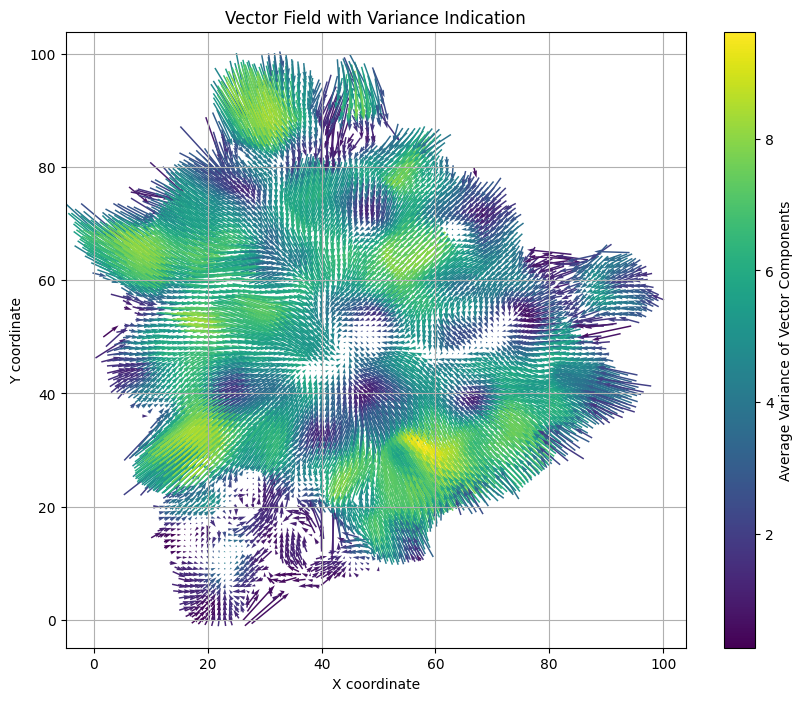

In [132]:
plot_vector_field_with_var(averaged,.7)

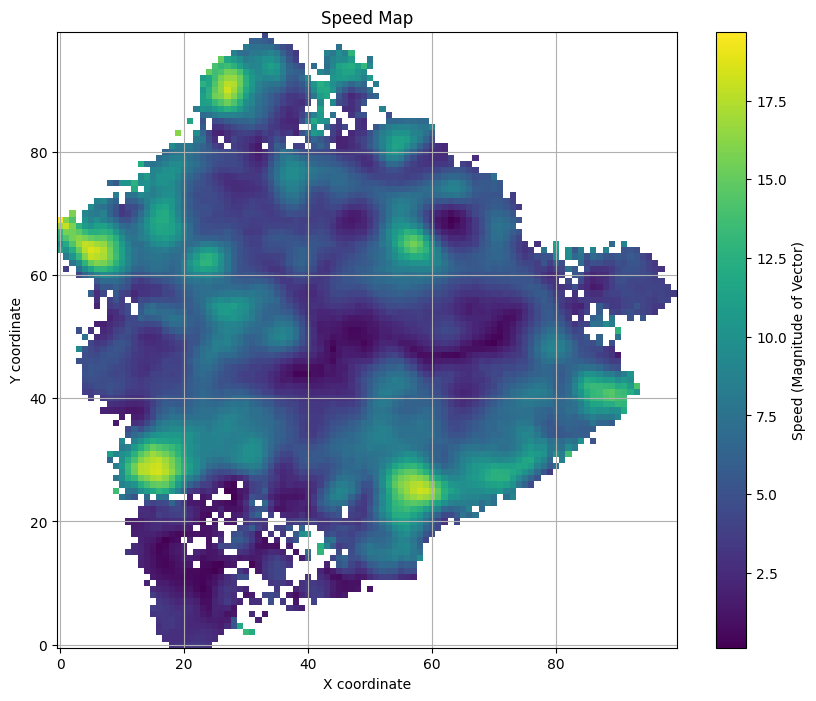

In [146]:
plot_speed_map(averaged)

## Step 3: Attractor identification

Here, we use the Runge-Kutte algorithm to estimate gradients and plot a flow map.  Note that we add an interpolation step here to enhance the estimate. 

In [115]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import multiprocessing as mp
from scipy.ndimage import generic_filter
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree

class DiscreteVectorFieldAnalyzer:
    def __init__(self, df, interpolation_factor=1, base_flow_threshold=1e-6):
        self.df = df
        self.interpolation_factor = interpolation_factor
        self.base_flow_threshold = base_flow_threshold
        self._prepare_data()

        # Calculate base step size for the rk4 step
        x_range = self.x_fine.max() - self.x_fine.min()
        y_range = self.y_fine.max() - self.y_fine.min()
        self.base_step_size = min(
            x_range / (len(self.x_fine) - 1),
            y_range / (len(self.y_fine) - 1)
        ) / 2

    def _prepare_data(self):
        # Extract original data
        x = self.df['from_x'].values
        y = self.df['from_y'].values
        u = self.df['mu_dx'].values
        v = self.df['mu_dy'].values

        # Create fine grid
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        # self.x_fine = np.linspace(x_min, x_max, int((x_max - x_min) * self.interpolation_factor))
        # self.y_fine = np.linspace(y_min, y_max, int((y_max - y_min) * self.interpolation_factor))

        # Center "pixels" to avoid systematic side bias
        step_size_field = (x_max - x_min) / (self.interpolation_factor * (x_max - x_min) - 1)
        self.x_fine = np.linspace(x_min, x_max, int((x_max - x_min) * self.interpolation_factor),endpoint=True) + (step_size_field / 2)
        self.y_fine = np.linspace(y_min, y_max, int((y_max - y_min) * self.interpolation_factor),endpoint=True) + (step_size_field / 2)


        self.X_fine, self.Y_fine = np.meshgrid(self.x_fine, self.y_fine)

        # Prepare points for interpolation
        points = np.column_stack((x, y))

        # Create Delaunay triangulation for the original points
        tri = Delaunay(points)

        # Interpolate U and V using LinearNDInterpolator
        self.U_interp = LinearNDInterpolator(points, u, fill_value=np.nan)
        self.V_interp = LinearNDInterpolator(points, v, fill_value=np.nan)

        # Apply interpolation
        self.U_fine = self.U_interp(self.X_fine, self.Y_fine)
        self.V_fine = self.V_interp(self.X_fine, self.Y_fine)

        # Create mask for valid data points
        # fine_points = np.column_stack((self.X_fine.ravel(), self.Y_fine.ravel()))
        # self.valid_mask = tri.find_simplex(fine_points) >= 0
        # self.valid_mask = self.valid_mask.reshape(self.X_fine.shape)

        # Create a more restrictive mask for valid data points
        fine_points = np.column_stack((self.X_fine.ravel(), self.Y_fine.ravel()))
        in_simplex = tri.find_simplex(fine_points) >= 0
        has_valid_values = ~np.isnan(self.U_fine.ravel()) & ~np.isnan(self.V_fine.ravel())
        self.valid_mask = (in_simplex & has_valid_values).reshape(self.X_fine.shape)

        # Apply mask to U_fine and V_fine
        self.U_fine[~self.valid_mask] = np.nan
        self.V_fine[~self.valid_mask] = np.nan

        self.grid_shape = self.X_fine.shape


    def generate_trajectory_rk4(self, start_index, sensitivity=1.0):
        """
        Generates a trajectory with divergence detection.
        """
        step_size = self.base_step_size / sensitivity
        max_steps = int(3 * np.sqrt(self.grid_shape[0]**2 + self.grid_shape[1]**2))
        
        trajectory = [start_index]
        current_x = self.X_fine[start_index[0], start_index[1]]
        current_y = self.Y_fine[start_index[0], start_index[1]]
        
        visited = set([start_index])
        
        # Keep track of flow directions for divergence detection
        flow_history = []
        
        def U_func(x, y):
            i, j = self.discretize_point((x, y))
            if np.isnan(self.U_fine[i, j]):
                return 0.0
            return self.U_fine[i, j]
            
        def V_func(x, y):
            i, j = self.discretize_point((x, y))
            if np.isnan(self.V_fine[i, j]):
                return 0.0
            return self.V_fine[i, j]
        
        flow_threshold = self.base_flow_threshold * sensitivity
        
        for step in range(max_steps):
            i, j = self.discretize_point((current_x, current_y))
            if not (0 <= i < self.grid_shape[0] and 0 <= j < self.grid_shape[1]):
                break
            if not self.valid_mask[i, j]:
                break
                
            # Get current flow vector
            u = U_func(current_x, current_y)
            v = V_func(current_x, current_y)
            delta_mag = np.hypot(u, v)
            
            if delta_mag < flow_threshold:
                break
                
            # Calculate flow direction and add to history
            flow_direction = np.arctan2(v, u)
            flow_history.append(flow_direction)
            
            # Check for sudden direction changes (potential separatrix crossing)
            if len(flow_history) > 5:  # Need some history to detect changes
                # Calculate rate of direction change
                direction_changes = np.diff(flow_history[-5:])
                # Wrap angles to [-pi, pi]
                direction_changes = np.mod(direction_changes + np.pi, 2*np.pi) - np.pi
                
                # If we detect significant direction change and aren't near zero flow
                if (np.abs(direction_changes).max() > np.pi/4 and  # 45 degree change
                    delta_mag > flow_threshold * 10):  # Not near stagnation
                    # Check neighborhood for divergent flows
                    neighborhood = self.get_neighborhood_flows(i, j, radius=2)
                    if self.is_divergent_region(neighborhood):
                        break  # Stop at potential separatrix
            
            next_x, next_y = self.rk4_step(current_x, current_y, step_size, U_func, V_func)
            
            next_i, next_j = self.discretize_point((next_x, next_y))
            if not (0 <= next_i < self.grid_shape[0] and 0 <= next_j < self.grid_shape[1]):
                break
            if not self.valid_mask[next_i, next_j]:
                break
                
            if (next_i, next_j) in visited:
                break
            visited.add((next_i, next_j))
            
            trajectory.append((next_i, next_j))
            current_x, current_y = next_x, next_y
            
        return trajectory

    def get_neighborhood_flows(self, i, j, radius=2):
        """Get flow vectors in neighborhood of point (i,j)."""
        neighborhood = []
        for di in range(-radius, radius+1):
            for dj in range(-radius, radius+1):
                ni, nj = i + di, j + dj
                if (0 <= ni < self.grid_shape[0] and 
                    0 <= nj < self.grid_shape[1] and 
                    self.valid_mask[ni, nj]):
                    u = self.U_fine[ni, nj]
                    v = self.V_fine[ni, nj]
                    if not (np.isnan(u) or np.isnan(v)):
                        neighborhood.append((u, v))
        return np.array(neighborhood)

    def is_divergent_region(self, flows, threshold=0.7):
        """
        Check if flows in a region are divergent.
        Uses cosine similarity to check if flows are pointing in different directions.
        """
        if len(flows) < 4:  # Need minimum number of valid flows
            return False
            
        # Normalize flows
        magnitudes = np.sqrt(np.sum(flows**2, axis=1))
        normalized_flows = flows / magnitudes[:, np.newaxis]
        
        # Calculate pairwise cosine similarities
        similarities = normalized_flows @ normalized_flows.T
        
        # Check if we have any significantly different directions
        return np.any(similarities < threshold)

    def process_point_rk4(self, args):
        index, sensitivity = args
        return self.generate_trajectory_rk4(index, sensitivity=sensitivity)

    def rk4_step(self,x, y, step_size, U, V):
        """
        One RK4 step at (x,y) with vector field (U,V).
        U and V are functions: U(x, y) -> dx/dt, V(x, y) -> dy/dt.
        step_size is the integration step.
        Returns (x_next, y_next).
        """
        # k1
        k1x = U(x, y)
        k1y = V(x, y)

        # k2
        k2x = U(x + 0.5 * step_size * k1x, y + 0.5 * step_size * k1y)
        k2y = V(x + 0.5 * step_size * k1x, y + 0.5 * step_size * k1y)

        # k3
        k3x = U(x + 0.5 * step_size * k2x, y + 0.5 * step_size * k2y)
        k3y = V(x + 0.5 * step_size * k2x, y + 0.5 * step_size * k2y)

        # k4
        k4x = U(x + step_size * k3x, y + step_size * k3y)
        k4y = V(x + step_size * k3x, y + step_size * k3y)

        # Combine
        x_next = x + (step_size / 6.0) * (k1x + 2*k2x + 2*k3x + k4x)
        y_next = y + (step_size / 6.0) * (k1y + 2*k2y + 2*k3y + k4y)

        return x_next, y_next



    def analyze_vector_field(self, sensitivity=1.0):
        """
        Analyze the vector field with a single control parameter.
        
        Args:
            sensitivity: Float between 0.1 and 2.0 that scales the derived parameters.
                Lower values are more conservative (fewer, larger attractors),
                higher values allow for more, smaller attractors.
        """
        valid_indices = list(zip(*np.where(self.valid_mask)))
        args = [(index, sensitivity) for index in valid_indices]
        
        with mp.Pool() as pool:
            trajectories = pool.map(self.process_point_rk4, args)
            
        return trajectories


    def discretize_point(self, point):
        """Convert a continuous point to the nearest grid index."""
        j = np.clip(np.searchsorted(self.x_fine, point[0]), 0, self.grid_shape[1] - 1)
        i = np.clip(np.searchsorted(self.y_fine, point[1]), 0, self.grid_shape[0] - 1)
        return (int(i), int(j))
        


    def vector_field(self, i, j):
        """Return the vector field at the given grid indices."""
        return np.array([self.U_fine[i, j], self.V_fine[i, j]])


    def find_attractors_and_basins(self, trajectories, sensitivity=1.0):
        """
        Identify attractors and their basins using adaptive parameters based on grid properties.
        
        Args:
            trajectories: List of trajectories from analyze_vector_field
            sensitivity: Controls clustering parameters, higher values allow smaller, more numerous attractors
        """
        valid_indices = list(zip(*np.where(self.valid_mask)))
        
        # Calculate grid-based parameters
        avg_grid_spacing = np.mean([
            self.x_fine[1] - self.x_fine[0],
            self.y_fine[1] - self.y_fine[0]
        ])
        
        # Scale DBSCAN parameters with sensitivity
        threshold = avg_grid_spacing * 2 / sensitivity
        samples = max(3, int(np.pi * (threshold/avg_grid_spacing)**2))
        min_quality = int(np.sqrt(self.grid_shape[0] * self.grid_shape[1]) / sensitivity)
        
        # Convert indices to coordinates for clustering
        end_indices = [t[-1] for t in trajectories]
        end_points = np.array([(self.X_fine[i, j], self.Y_fine[i, j]) for i, j in end_indices])
        
        clustering = DBSCAN(eps=threshold, min_samples=samples).fit(end_points)
        
        unique_labels = np.unique(clustering.labels_)
        print(f"Unique labels: {unique_labels}")
        attractors = []
        valid_labels = {}  # Dictionary to map DBSCAN labels to new attractor indices
        new_label = 0  # Counter for new labels
        
        for label in unique_labels:
            if label != -1:  # -1 is noise in DBSCAN
                cluster_points = end_points[clustering.labels_ == label]
                quality = 0
                cluster_indices = np.where(clustering.labels_ == label)[0]
                for idx in cluster_indices:
                    quality += len(trajectories[idx])
                if quality > min_quality:
                    attractors.append(np.mean(cluster_points, axis=0))
                    valid_labels[label] = new_label
                    new_label += 1
        
        attractors = np.array(attractors)
        print(f"Number of attractors after pruning: {len(attractors)}")
        
        # Assign basins
        basins = np.full(self.grid_shape, -1, dtype=int)
        for (i, j), label in zip(valid_indices, clustering.labels_):
            basins[i, j] = valid_labels.get(label, -1)
        
        # Fill pruned basins with nearest valid basin
        valid_points = []
        valid_labels_list = []
        for i, j in valid_indices:
            if basins[i, j] != -1:
                valid_points.append((self.X_fine[i, j], self.Y_fine[i, j]))
                valid_labels_list.append(basins[i, j])
        
        if not valid_points:
            print("Warning: All attractors were pruned.")
            return attractors, basins  # Return if no valid points (all attractors pruned)
        
        tree = cKDTree(valid_points)
        
        pruned_points = []
        pruned_indices = []
        for i, j in valid_indices:
            if basins[i, j] == -1:
                pruned_points.append((self.X_fine[i, j], self.Y_fine[i, j]))
                pruned_indices.append((i, j))
        
        if pruned_points:
            distances, indices = tree.query(pruned_points, k=1)
            for (i, j), idx in zip(pruned_indices, indices):
                basins[i, j] = valid_labels_list[idx]
        
        return attractors, basins

    def analyze_field(self, sensitivity=1.0):
        """
        Complete analysis pipeline with a single control parameter.
        
        Args:
            sensitivity: Float between 0.1 and 2.0 that controls the overall analysis.
                Lower values are more conservative (fewer, larger attractors),
                higher values allow for more, smaller attractors.
        
        Returns:
            tuple: (attractors, basins)
        """
        trajectories = self.analyze_vector_field(sensitivity=sensitivity)
        return self.find_attractors_and_basins(trajectories, sensitivity=sensitivity)

    def plot_results(self, attractors, basins):
        plt.figure(figsize=(12, 10))
        masked_basins = np.ma.masked_where(~self.valid_mask, basins)
        plt.imshow(masked_basins, extent=[self.x_fine.min(), self.x_fine.max(), 
                                            self.y_fine.min(), self.y_fine.max()],
                    origin='lower', alpha=0.6, cmap='viridis')
        plt.streamplot(self.X_fine, self.Y_fine, self.U_fine, self.V_fine, 
                        density=3, color='gray', arrowsize=0.5)
        plt.scatter(attractors[:, 0], attractors[:, 1], c='red', s=100, label='Attractors')
        plt.colorbar(label='Basin of Attraction')
        plt.title('Vector Field with Basins of Attraction')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.legend()
        plt.show()

Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32]
Number of attractors after pruning: 16


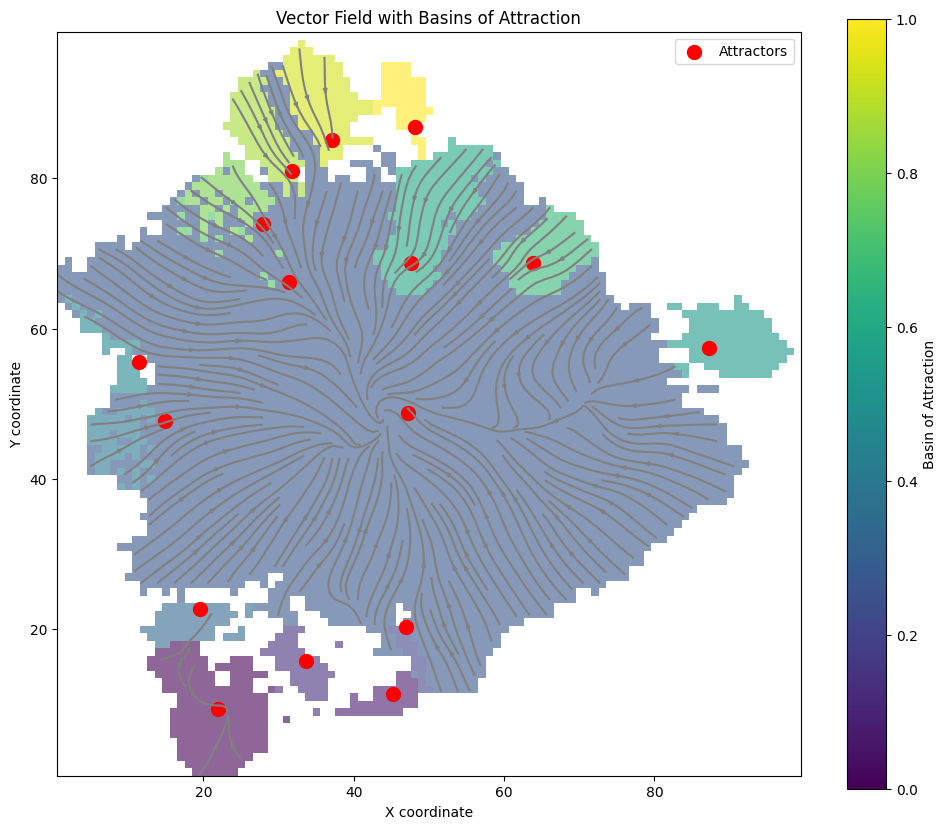

In [128]:
#Old version
# analyzer = DiscreteVectorFieldAnalyzer(averaged, interpolation_factor=2)
# trajectories = analyzer.analyze_vector_field(step_size=.1)
# attractors, basins = analyzer.find_attractors_and_basins(trajectories,min_quality=500,threshold=.6,samples=10)

analyzer = DiscreteVectorFieldAnalyzer(averaged, interpolation_factor=1)
attractors, basins = analyzer.analyze_field(sensitivity=1.7)
analyzer.plot_results(attractors, basins)



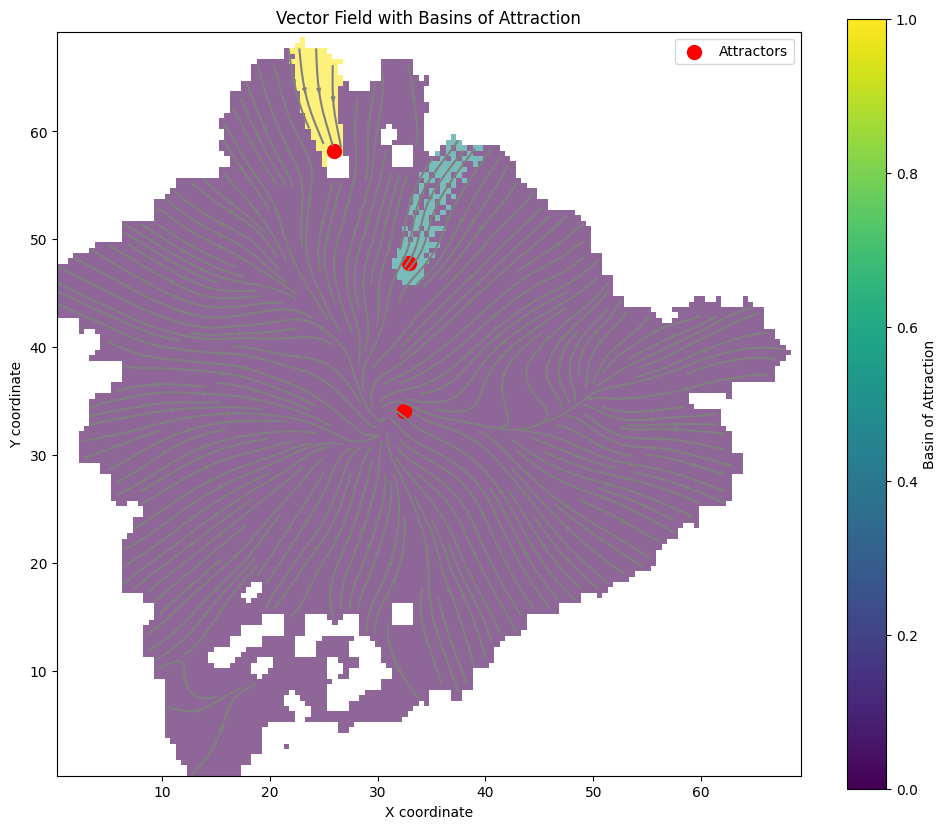